<a href="https://colab.research.google.com/github/alexandreib/QuantDesign/blob/main/QD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
def is_gpu():
    from tensorflow.python.client import device_lib # when only CPU is enabled the list shows two CPU entries, otherwise there are more, listing GPU as well
    return len(device_lib.list_local_devices()) >= 2

def in_colab():
    return True if 'google.colab' in str(get_ipython()) else False

if in_colab():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import copy

In [24]:
CFG = {}
CFG['verbose'] = True
CFG['l_resamples'] = ['30min', '60min', 'D']

In [25]:
# raw =[]
# with open('/content/drive/MyDrive/QuantDesign/GCESIE_1min.txt') as file:
#     for i, line in enumerate(file):
#         if i > 2 :
#             line = line.split(' ')
#             idx_date = -7
#             idx_time = -6
#             idx_close= -2
#             raw.append({'index' : i, 'date' : line[idx_date], 'time' : line[idx_time][:-1], 'close' : line[idx_close][:-1],})
#         else :
#             print(line)
# raw = pd.DataFrame(raw).set_index('index')
# raw['datetime'] = pd.to_datetime(raw['date'] + ' ' + raw['time'])
# raw['close'] = raw['close'].astype(float)
# raw.to_parquet('/content/drive/MyDrive/QuantDesign/GCESIE_1min.parquet')

raw = pd.read_parquet('/content/drive/MyDrive/QuantDesign/GCESIE_1min.parquet')

if CFG['verbose'] : display(raw.head())
if CFG['verbose'] : print(raw.shape)

,date,time,close,datetime
index,,,,
3,2009-08-07,05:24:00.000,65.12437,2009-08-07 05:24:00
4,2009-08-07,05:25:00.000,65.11230,2009-08-07 05:25:00
5,2009-08-07,05:26:00.000,65.11765,2009-08-07 05:26:00
6,2009-08-07,05:27:00.000,65.11230,2009-08-07 05:27:00
7,2009-08-07,05:28:00.000,65.09888,2009-08-07 05:28:00


(4689486, 4)


In [26]:
ldf = []

for i, resample in enumerate(CFG['l_resamples']) :
    ldf.append(pd.concat([raw[['datetime','close']].set_index('datetime').resample(resample).first().rename(columns = {'close':'open'}),
                raw[['datetime','close']].set_index('datetime').resample(resample).last().rename(columns = {'close':'close'}),
                raw[['datetime','close']].set_index('datetime').resample(resample).max().rename(columns = {'close':'high'}),
                raw[['datetime','close']].set_index('datetime').resample(resample).min().rename(columns = {'close':'low'}),
                raw[['datetime','close']].set_index('datetime').resample(resample).mean().rename(columns = {'close':'mean'}),
            ], axis = 1).dropna().reset_index())
    if CFG['verbose'] : display(ldf[i].head())

,datetime,open,close,high,low,mean
0,2009-08-07 05:00:00,65.12437,65.11093,65.12437,65.09888,65.112738
1,2009-08-07 05:30:00,65.12163,65.08547,65.12163,64.98133,65.065983
2,2009-08-07 06:00:00,65.03336,65.00000,65.12025,65.00000,65.050941
3,2009-08-07 06:30:00,65.03467,65.01599,65.05600,64.93078,65.001040
4,2009-08-07 07:00:00,65.01599,64.77327,65.02266,64.69404,64.912555


,datetime,open,close,high,low,mean
0,2009-08-07 05:00:00,65.12437,65.08547,65.12437,64.98133,65.073775
1,2009-08-07 06:00:00,65.03336,65.01599,65.12025,64.93078,65.025991
2,2009-08-07 07:00:00,65.01599,64.39915,65.02266,64.39915,64.776834
3,2009-08-07 08:00:00,64.40445,64.70839,64.70839,64.34461,64.485150
4,2009-08-07 09:00:00,64.78377,64.76927,65.00268,64.64732,64.827314


,datetime,open,close,high,low,mean
0,2009-08-07,65.12437,64.79701,65.12437,64.34461,64.806483
1,2009-08-09,64.95580,64.67110,65.13426,64.61620,64.864103
2,2009-08-10,64.64323,65.10005,65.53272,64.64323,65.117869
3,2009-08-11,65.09464,65.43183,65.55647,64.88698,65.272939
4,2009-08-12,65.42097,64.69863,65.74171,64.55493,65.053141


In [27]:
def calculate_twap(df, column = 'mean', episode = 2):
  return df[column].rolling(episode).mean().array

def ATR(df, window = 14):
    High_minus_Low = df['high'] - df['low']
    High_minus_Close = abs(df['high'] - df['close'].shift(1))
    Low_minus_Close = abs(df['low'] - df['close'].shift(1))
    TR = pd.concat([High_minus_Low, High_minus_Close, Low_minus_Close], axis=1).max(axis=1)
    return TR.ewm(alpha=1 / window).mean()

for i, df in enumerate(ldf) :
    df = ldf[i]
    df[f'TWAP_10'] = calculate_twap(df, episode = 10)
    df[f'TWAP_20'] = calculate_twap(df, episode = 20)
    df[f'TWAP_30'] = calculate_twap(df, episode = 30)
    df[f'TWAP_40'] = calculate_twap(df, episode = 40)

    df['ATR'] = ATR(df) # Other option : talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)

    df = df.dropna().reset_index(drop = True)
    ldf[i] = df
    if CFG['verbose'] : display(df.tail())

,datetime,open,close,high,low,mean,TWAP_10,TWAP_20,TWAP_30,TWAP_40,ATR
157064,2022-10-07 13:30:00,84.54411,84.62264,84.62264,84.44939,84.532814,84.308497,83.706604,83.392293,83.344386,0.326184
157065,2022-10-07 14:00:00,84.57072,84.92761,84.93759,84.56689,84.725474,84.359116,83.811900,83.459012,83.378484,0.329364
157066,2022-10-07 14:30:00,84.91141,84.63106,84.91141,84.63106,84.776261,84.429567,83.914765,83.524809,83.414197,0.327020
157067,2022-10-07 15:00:00,84.67545,84.55426,84.67926,84.54207,84.593676,84.475874,84.000225,83.585352,83.443340,0.313460
157068,2022-10-07 15:30:00,84.52831,84.41468,84.52831,84.35472,84.446085,84.485622,84.070588,83.644132,83.469141,0.305323


,datetime,open,close,high,low,mean,TWAP_10,TWAP_20,TWAP_30,TWAP_40,ATR
79294,2022-10-07 11:00:00,84.42251,84.54568,84.54568,84.13844,84.320674,83.370506,83.226103,83.313217,83.302833,0.452662
79295,2022-10-07 12:00:00,84.50990,84.43016,84.61577,84.19990,84.375927,83.531452,83.286075,83.340275,83.331011,0.450034
79296,2022-10-07 13:00:00,84.42522,84.62264,84.62264,84.30618,84.460760,83.706604,83.344386,83.373894,83.359412,0.440493
79297,2022-10-07 14:00:00,84.57072,84.63106,84.93759,84.56689,84.750867,83.914765,83.414197,83.420200,83.400439,0.435507
79298,2022-10-07 15:00:00,84.67545,84.41468,84.67926,84.35472,84.519880,84.070588,83.469141,83.450971,83.439969,0.427581


,datetime,open,close,high,low,mean,TWAP_10,TWAP_20,TWAP_30,TWAP_40,ATR
4052,2022-10-03,87.00521,81.77554,87.01900,81.47830,83.732625,87.499961,87.570431,90.098847,90.673168,1.960058
4053,2022-10-04,81.73601,82.75994,82.91957,81.25623,82.078648,87.145904,87.094484,89.686520,90.464150,1.938863
4054,2022-10-05,82.74426,82.90500,85.44727,82.37473,83.545936,86.820290,86.828094,89.259552,90.253057,2.019840
4055,2022-10-06,82.88107,82.84129,84.09892,82.59428,83.356486,86.321679,86.586234,88.804583,90.027785,1.983040
4056,2022-10-07,82.84061,84.41468,84.93759,82.53899,83.587001,85.838074,86.386233,88.382045,89.807947,2.012723


In [28]:
dict_colors = {'close': 'brown',
               'TWAP_10': 'black',
               'TWAP_20': 'green',
               'TWAP_30': 'red',
               'TWAP_40': 'blue'}

last_x_point = 1000

fig = make_subplots(rows=2, cols=len(ldf))
for i, df in enumerate(ldf) :
    for col in dict_colors :
        fig.add_trace(go.Scatter(x = df['datetime'].tail(last_x_point),
                                 y = df[col].tail(last_x_point),
                                 mode = 'lines',
                                 name = col,
                                 line=dict(color=dict_colors[col])),
                      row = 1, col = i+1)

    fig.add_trace(go.Scatter(x = df['datetime'].tail(last_x_point),
                                y = df['ATR'].tail(last_x_point),
                                mode = 'lines',
                                name = 'ATR',
                                line=dict(color='orange', width=2)),
                    row=2, col= i+1)

fig.update_layout( title='Spread Gold', height=600,
    margin=dict(l=10, r=10, t=30, b=10),
    showlegend=True,
)

fig.show()

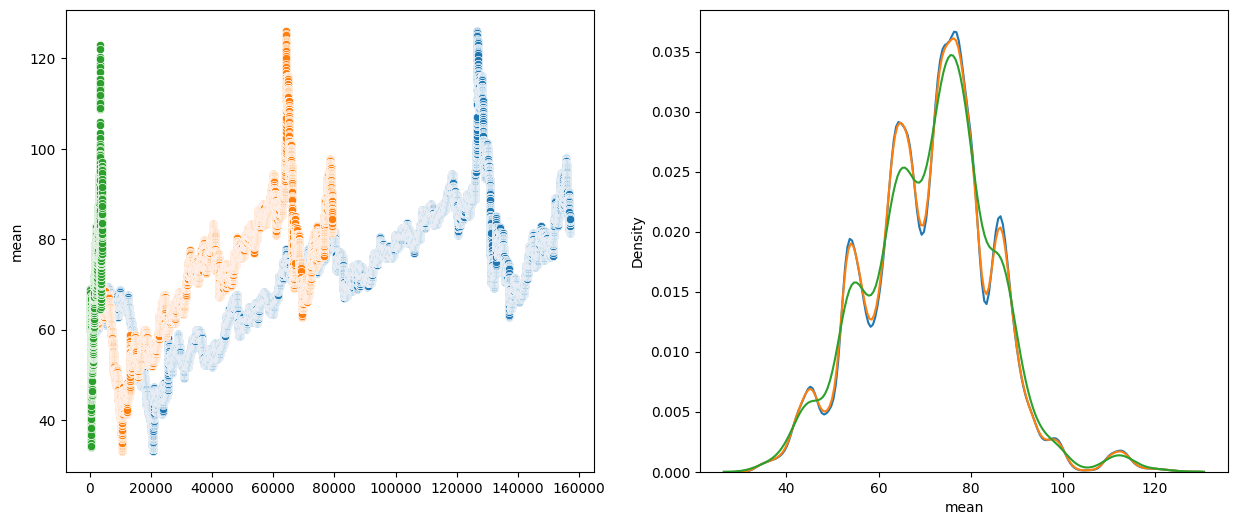

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
for i, df in enumerate(ldf) :
    sns.scatterplot(df['mean'], ax = ax1,)
    sns.kdeplot(df['mean'], ax = ax2, )
plt.show()

In [30]:
df = copy.deepcopy(ldf[0])
df.columns = df.columns + '_' + CFG['l_resamples'][0]

for i, dft in enumerate(ldf[1:]) :
    dft = dft.drop(['open', 'close', 'high', 'low',  'mean'], axis = 1)
    dft.columns = dft.columns + '_' + CFG['l_resamples'][i+1]
    dft[f"datetime_{CFG['l_resamples'][i+1]}"] = dft[f"datetime_{CFG['l_resamples'][i+1]}"].shift(-1)
    df = df.merge(dft, left_on = f"datetime_{CFG['l_resamples'][0]}", right_on = f"datetime_{CFG['l_resamples'][i+1]}", how = 'left')

df = df.ffill().dropna()

if CFG['verbose'] : display(df.head())
if CFG['verbose'] : display(df.tail())

,datetime_30min,open_30min,close_30min,high_30min,low_30min,mean_30min,TWAP_10_30min,TWAP_20_30min,TWAP_30_30min,TWAP_40_30min,...,TWAP_20_60min,TWAP_30_60min,TWAP_40_60min,ATR_60min,datetime_D,TWAP_10_D,TWAP_20_D,TWAP_30_D,TWAP_40_D,ATR_D
1492,2009-09-23 00:00:00,59.78898,59.86848,59.87315,59.78898,59.831823,59.893771,59.905182,59.908090,59.869677,...,59.872177,59.936069,60.010799,0.176857,2009-09-23,60.171068,61.142348,62.663672,63.213207,0.974632
1493,2009-09-23 00:30:00,59.86378,59.94825,59.94825,59.83099,59.865955,59.887586,59.896858,59.908226,59.868529,...,59.872177,59.936069,60.010799,0.176857,2009-09-23,60.171068,61.142348,62.663672,63.213207,0.974632
1494,2009-09-23 01:00:00,59.92944,59.95758,60.01887,59.92944,59.966265,59.895010,59.897581,59.910604,59.871398,...,59.870537,59.922490,59.996531,0.175601,2009-09-23,60.171068,61.142348,62.663672,63.213207,0.974632
1495,2009-09-23 01:30:00,59.96229,60.05195,60.08030,59.94346,59.990277,59.901210,59.898508,59.916325,59.879004,...,59.870537,59.922490,59.996531,0.175601,2009-09-23,60.171068,61.142348,62.663672,63.213207,0.974632
1496,2009-09-23 02:00:00,60.01888,59.90582,60.03304,59.83071,59.944896,59.899329,59.899568,59.917915,59.884178,...,59.883852,59.912536,59.986731,0.173834,2009-09-23,60.171068,61.142348,62.663672,63.213207,0.974632


,datetime_30min,open_30min,close_30min,high_30min,low_30min,mean_30min,TWAP_10_30min,TWAP_20_30min,TWAP_30_30min,TWAP_40_30min,...,TWAP_20_60min,TWAP_30_60min,TWAP_40_60min,ATR_60min,datetime_D,TWAP_10_D,TWAP_20_D,TWAP_30_D,TWAP_40_D,ATR_D
157064,2022-10-07 13:30:00,84.54411,84.62264,84.62264,84.44939,84.532814,84.308497,83.706604,83.392293,83.344386,...,83.286075,83.340275,83.331011,0.450034,2022-10-07,86.321679,86.586234,88.804583,90.027785,1.98304
157065,2022-10-07 14:00:00,84.57072,84.92761,84.93759,84.56689,84.725474,84.359116,83.811900,83.459012,83.378484,...,83.344386,83.373894,83.359412,0.440493,2022-10-07,86.321679,86.586234,88.804583,90.027785,1.98304
157066,2022-10-07 14:30:00,84.91141,84.63106,84.91141,84.63106,84.776261,84.429567,83.914765,83.524809,83.414197,...,83.344386,83.373894,83.359412,0.440493,2022-10-07,86.321679,86.586234,88.804583,90.027785,1.98304
157067,2022-10-07 15:00:00,84.67545,84.55426,84.67926,84.54207,84.593676,84.475874,84.000225,83.585352,83.443340,...,83.414197,83.420200,83.400439,0.435507,2022-10-07,86.321679,86.586234,88.804583,90.027785,1.98304
157068,2022-10-07 15:30:00,84.52831,84.41468,84.52831,84.35472,84.446085,84.485622,84.070588,83.644132,83.469141,...,83.414197,83.420200,83.400439,0.435507,2022-10-07,86.321679,86.586234,88.804583,90.027785,1.98304


In [31]:
df['diff_10_30min'] = diff_10_30min = df['close_30min'] - df[f'TWAP_10_30min']
df['diff_20_30min'] = diff_20_30min = df['close_30min'] - df[f'TWAP_20_30min']
df['diff_30_30min'] = diff_30_30min = df['close_30min'] - df[f'TWAP_30_30min']
df['diff_40_30min'] = diff_40_30min = df['close_30min'] - df[f'TWAP_40_30min']

df['diff_10_60min'] = diff_10_60min = df['close_30min'] - df[f'TWAP_10_60min']
df['diff_20_60min'] = diff_20_60min = df['close_30min'] - df[f'TWAP_20_60min']
df['diff_30_60min'] = diff_30_60min = df['close_30min'] - df[f'TWAP_30_60min']
df['diff_40_60min'] = diff_40_60min = df['close_30min'] - df[f'TWAP_40_60min']

df['diff_10_D'] = diff_10_D = df['close_30min'] - df[f'TWAP_10_D']
df['diff_20_D'] = diff_20_D = df['close_30min'] - df[f'TWAP_20_D']
df['diff_30_D'] = diff_30_D = df['close_30min'] - df[f'TWAP_30_D']
df['diff_40_D'] = diff_40_D = df['close_30min'] - df[f'TWAP_40_D']

df['Log_Return'] = Log_Return = np.log(df['close_30min'] / df['close_30min'].shift(1))


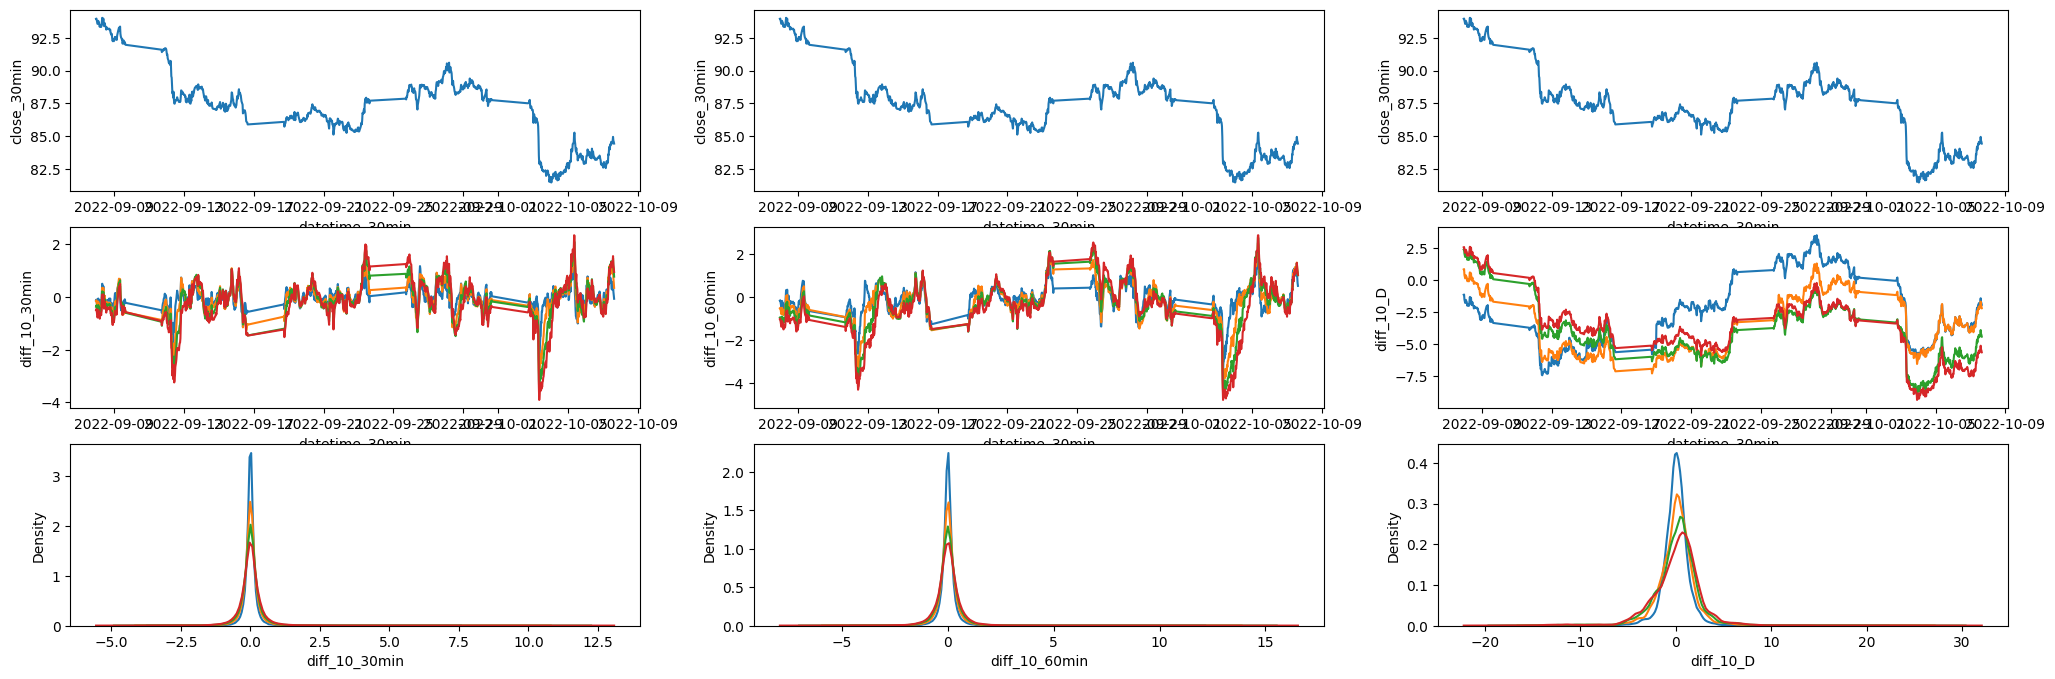

In [32]:
fig, ax = plt.subplots(3, 3, figsize=(25, 8))
for i, resample in enumerate(CFG['l_resamples']) :
    sns.lineplot(data = df.tail(last_x_point), x ='datetime_30min' ,y = 'close_30min', ax = ax[0][i])

    sns.lineplot(data = df.tail(last_x_point), x ='datetime_30min' ,y = f'diff_10_{resample}', ax = ax[1][i])
    sns.lineplot(data = df.tail(last_x_point), x ='datetime_30min' ,y = f'diff_20_{resample}', ax = ax[1][i])
    sns.lineplot(data = df.tail(last_x_point), x ='datetime_30min' ,y = f'diff_30_{resample}', ax = ax[1][i])
    sns.lineplot(data = df.tail(last_x_point), x ='datetime_30min' ,y = f'diff_40_{resample}', ax = ax[1][i])

    sns.kdeplot(df[f'diff_10_{resample}'], ax = ax[2][i])
    sns.kdeplot(df[f'diff_20_{resample}'], ax = ax[2][i])
    sns.kdeplot(df[f'diff_30_{resample}'], ax = ax[2][i])
    sns.kdeplot(df[f'diff_40_{resample}'], ax = ax[2][i])

plt.show()

In [36]:
def calculate_index(weights, threshold):
    global Log_Return, diff_10_30min, diff_20_30min, diff_30_30min, diff_40_30min, diff_10_60min, diff_20_60min, diff_30_60min, diff_40_60min, diff_10_D, diff_20_D, diff_30_D, diff_40_D
    index = (weights[0] * diff_10_30min + weights[1] * diff_20_30min + weights[2] * diff_30_30min + weights[3] * diff_40_30min + \
             weights[4] * diff_10_60min + weights[5] * diff_20_60min + weights[6] * diff_30_60min + weights[7] * diff_40_60min + \
             weights[8] * diff_10_D + weights[9] * diff_20_D + weights[10] * diff_30_D + weights[11] * diff_40_D
             ).shift().fillna(0)
    index[threshold > np.abs(index)] = 0
    return index

def calculate_returns(weights, threshold):
    index = np.sign(calculate_index(weights, threshold))
    return -1 * np.sum(index * Log_Return)

number_of_weights = len(CFG['l_resamples']) * 4
weights = [1/number_of_weights for i in range(number_of_weights)]
threshold = 2

def optimize_weights(threshold = 0) :
    result = sp.optimize.minimize(fun = calculate_returns,
                                x0 = [1/number_of_weights for i in range(number_of_weights)],
                                args = (threshold),
                                method = 'SLSQP',
                                bounds = tuple((0.01, 0.5) for _ in range(number_of_weights)),
                                constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
                                )

    return result


results = {}
best_result = 1000
l_results = []
thresholds = np.linspace(0, 15, 30, endpoint=False)

for threshold in thresholds:
    results[threshold] = optimize_weights(threshold)
    l_results.append(results[threshold].fun)
    if results[threshold].fun < best_result :
        best_result = results[threshold].fun
        best_weights = results[threshold].x
        best_threshold = threshold
    if CFG['verbose'] : print(threshold, results[threshold].fun, np.sum(results[threshold].x))

if CFG['verbose'] : print(best_result, best_weights, best_threshold)

0.0 1.5449088034875373 1.0
0.5 0.8849107655299693 1.0
1.0 0.02752023664873155 1.0
1.5 -0.035934153175708736 1.0
2.0 0.15831082945262925 1.0
2.5 0.005503715460603298 1.0
3.0 -0.1771761327279555 1.0
3.5 -0.14777331307599845 1.0
4.0 -0.08903536308609811 1.0
4.5 0.04703899859513286 1.0
5.0 0.07407145372458704 1.0
5.5 0.05254266608156907 1.0
6.0 0.015895933871442065 1.0
6.5 0.00411348520126701 1.0
7.0 0.02154031524210892 1.0
7.5 0.012309835016822774 1.0
8.0 0.059617071711080806 1.0
8.5 0.03661946129567838 1.0
9.0 0.02116344868218785 1.0
9.5 0.04273456281521302 1.0
10.0 0.06160423292917396 1.0
10.5 0.050540295185825285 1.0
11.0 0.03009047641504881 1.0
11.5 0.01727278520324519 1.0
12.0 0.001041991305871029 1.0
12.5 0.025443119604472347 1.0
13.0 0.04060226596266757 1.0
13.5 0.055880140256954675 1.0
14.0 0.055880140256954675 1.0
14.5 0.06551219676720586 1.0
-0.1771761327279555 [0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 0.08333333 0.08333333 0.08333333 0.08333333 0.08333

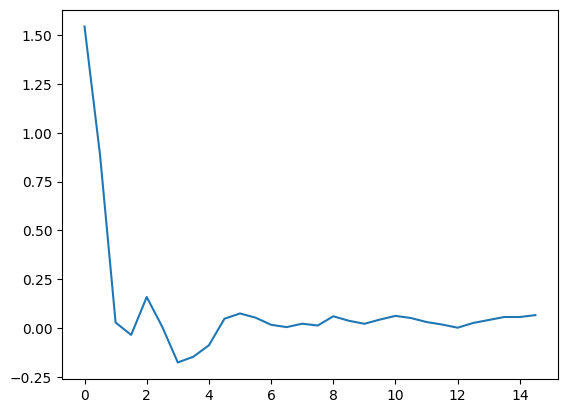

In [37]:
sns.lineplot(x = thresholds, y = l_results)
plt.show()

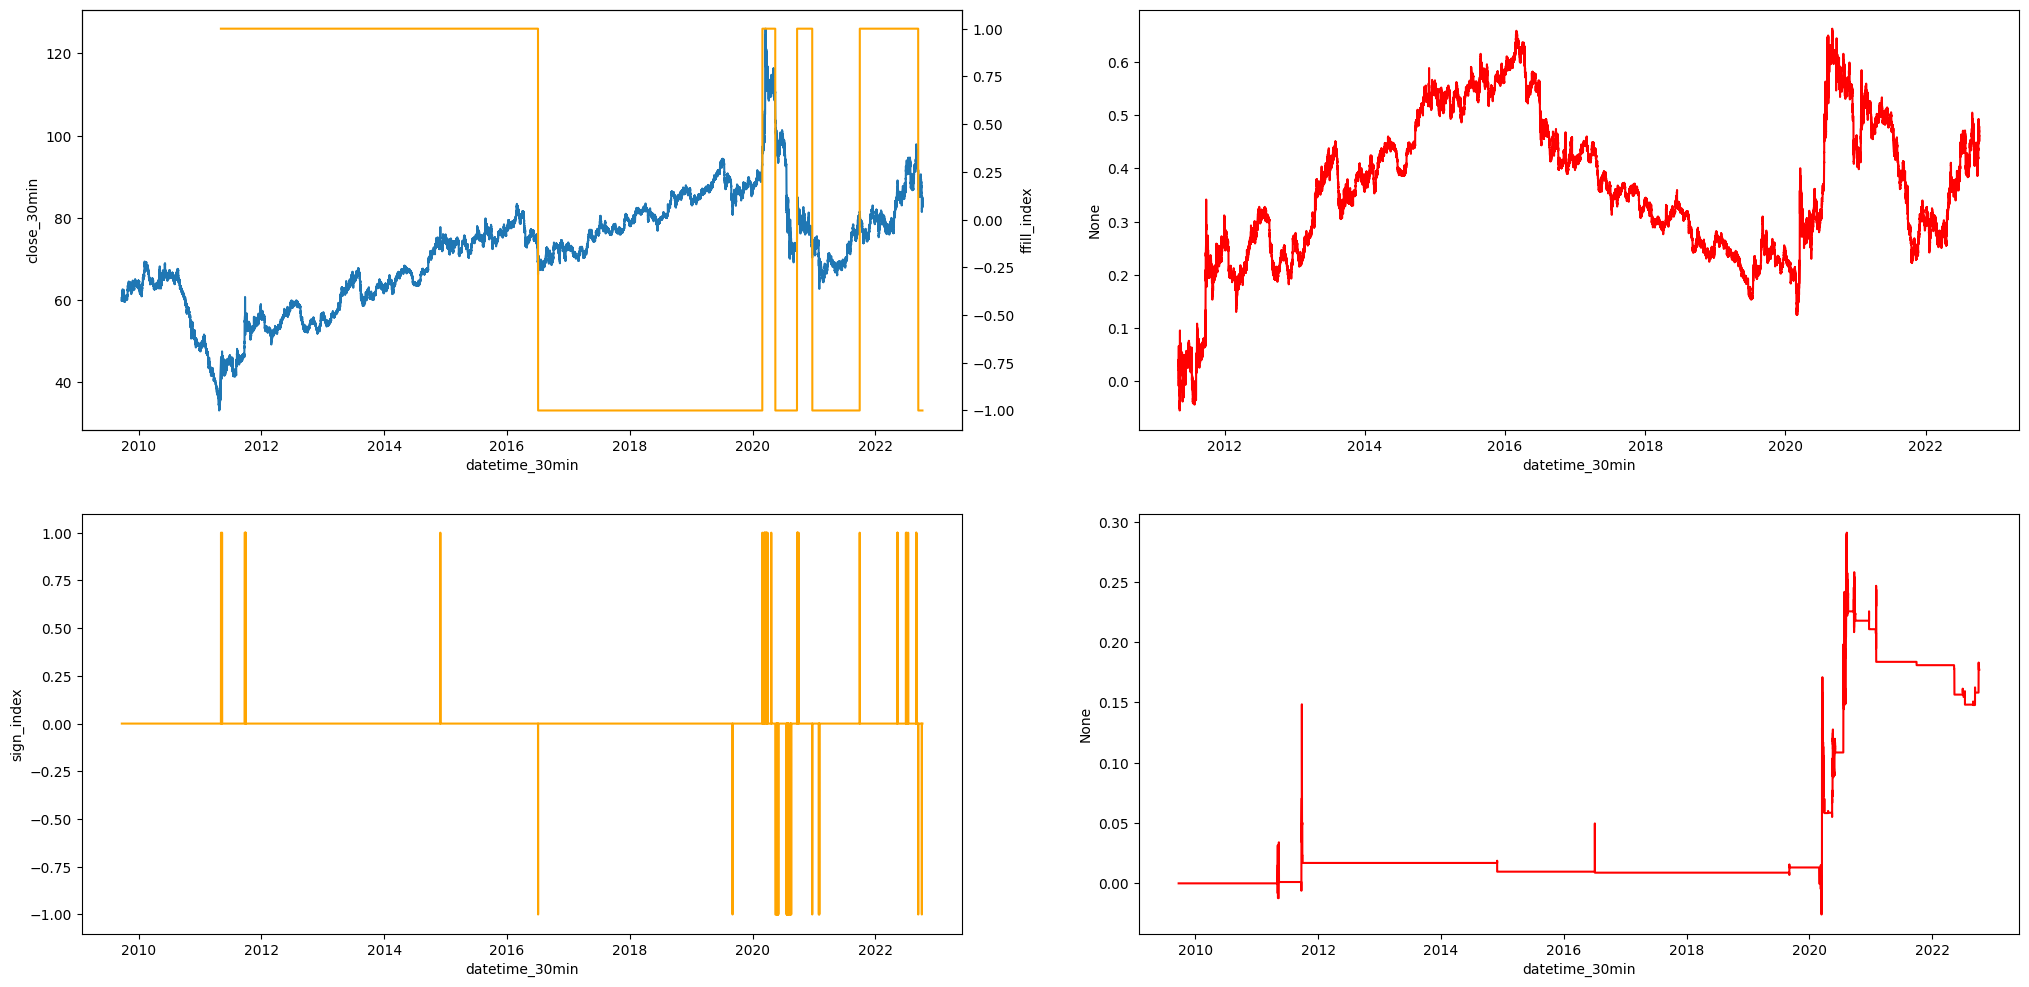

In [61]:
index = calculate_index(best_weights, best_threshold)

df['index'] = index
df['sign_index'] = sign_index = np.sign(index)
df['ffill_index'] = sign_index.replace(0, np.nan).ffill()
df['cumsum_index'] = np.cumsum(index)

fig, ax = plt.subplots(2, 2, figsize=(25, 12))

# sns.lineplot(df['close_30min'].tail(100000), ax = ax1)
sns.lineplot(data = df, x='datetime_30min', y='close_30min', ax = ax[0][0])
ax2 = ax[0][0].twinx()
# sns.lineplot(data = df, x='datetime_30min', y='sign_index', ax = ax2, color = 'red')
sns.lineplot(data = df, x='datetime_30min', y='ffill_index', ax = ax2, color = 'orange')

sns.lineplot(data = df, x='datetime_30min', y='sign_index', ax = ax[1][0], color = 'orange')
# sns.lineplot(data = df, x='datetime_30min', y='sign_index', ax = ax[1][0], color = 'orange')

# sns.lineplot(data = df, x='datetime_30min', y='close_30min', ax = ax[0][1])
ax3 = ax[0][1]#.twinx()
sns.lineplot(data = df, x='datetime_30min', y= np.cumsum(df['Log_Return'] * df['ffill_index']), ax = ax3, color = 'red')

# sns.lineplot(data = df, x='datetime_30min', y='close_30min', ax = ax[1][1])
ax4 = ax[1][1]#.twinx()
sns.lineplot(data = df, x='datetime_30min', y= np.cumsum(df['Log_Return'] * df['sign_index']), ax = ax4, color = 'red')

plt.show()

In [47]:
display(df.tail())

,datetime_30min,open_30min,close_30min,high_30min,low_30min,mean_30min,TWAP_10_30min,TWAP_20_30min,TWAP_30_30min,TWAP_40_30min,...,diff_40_60min,diff_10_D,diff_20_D,diff_30_D,diff_40_D,Log_Return,index,ffill_index,cumsum_index,sign_index
157064,2022-10-07 13:30:00,84.54411,84.62264,84.62264,84.44939,84.532814,84.308497,83.706604,83.392293,83.344386,...,1.291629,-1.699039,-1.963594,-4.181943,-5.405145,0.001482,0.0,-1.0,-940.187765,0.0
157065,2022-10-07 14:00:00,84.57072,84.92761,84.93759,84.56689,84.725474,84.359116,83.811900,83.459012,83.378484,...,1.568198,-1.394069,-1.658624,-3.876973,-5.100175,0.003597,0.0,-1.0,-940.187765,0.0
157066,2022-10-07 14:30:00,84.91141,84.63106,84.91141,84.63106,84.776261,84.429567,83.914765,83.524809,83.414197,...,1.271648,-1.690619,-1.955174,-4.173523,-5.396725,-0.003498,0.0,-1.0,-940.187765,0.0
157067,2022-10-07 15:00:00,84.67545,84.55426,84.67926,84.54207,84.593676,84.475874,84.000225,83.585352,83.443340,...,1.153821,-1.767419,-2.031974,-4.250323,-5.473525,-0.000908,0.0,-1.0,-940.187765,0.0
157068,2022-10-07 15:30:00,84.52831,84.41468,84.52831,84.35472,84.446085,84.485622,84.070588,83.644132,83.469141,...,1.014241,-1.906999,-2.171554,-4.389903,-5.613105,-0.001652,0.0,-1.0,-940.187765,0.0
